20 September 2017

Notebook for testing sklearn algorithms for selection of $2.9<z$ quasars from SDSS+SpIES.

# Training Data


In [1]:
# Read in data file
%matplotlib inline
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
#data = Table.read('GTR-ADM-QSO-Trainingset-with-McGreer-VVDS-DR12Q_splitlabel.fits')
data = Table.read('/Users/johntimlin/Catalogs/QSO_candidates/Training_set/GTR-ADM-QSO-Trainingset-with-McGreer-VVDS-DR12Q_splitlabel_VCVcut_best.fits')
labname = 'shenlabel'

# X is in the format need for all of the sklearn tools, it just has the colors
X = np.vstack([np.asarray(data[name]) for name in ['ug', 'gr', 'ri', 'iz', 'zs1', 's1s2']]).T
y = np.array(data[labname])

# If we want to make a scaled version of X (i.e., set the mean of each attribute to zero and the variance to 1)
from sklearn.preprocessing import StandardScaler 
XS = StandardScaler().fit_transform(X)

# List the attributes that are available to train on?
print data.keys()



['ug', 'gr', 'ri', 'iz', 'zs1', 's1s2', 'ra', 'dec', 'iflux', 'zspec', 'extinctu', 'imag', 'morph', 'labels', 'shenlabel', 'hzlabel', 'lzlabel', 'Catalog']


In [2]:
# Make training and test sets
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report

# Split the training data into training and test sets for cross-validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

# Do the same for the scaled data sets
XStrain, XStest, yStrain, yStest = train_test_split(XS, y, test_size=0.25, random_state=42)

In [3]:
### PLOT THE COLORS

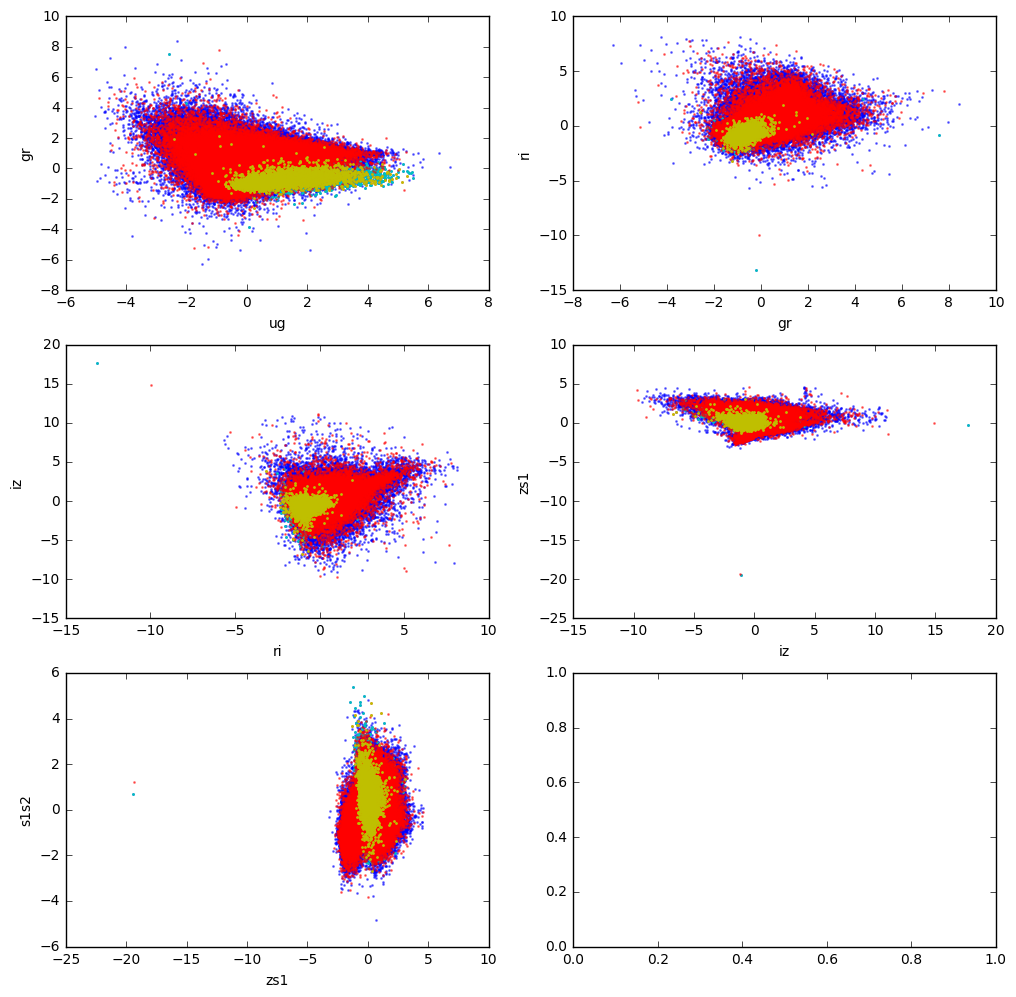

In [112]:
import matplotlib.gridspec as gridspec

gdx = yStrain == 0
bdx = yStest == 0
fig = plt.figure(1,figsize = (12,12))

gs = gridspec.GridSpec(3,2)#,width_ratios = [1,1,1,1,1,1], height_ratios = [1,1,1,1,1,1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

for i in range(5):
    name = [ax0,ax1,ax2,ax3,ax4,ax5]
    lab = ['ug','gr','ri','iz','zs1','s1s2']
    plt.axes(name[i])
    plt.scatter(XStrain[:,i],XStrain[:,i+1],s=1,alpha=0.5,color = 'b')
    plt.scatter(XStrain[:,i][gdx],XStrain[:,i+1][gdx],s=1,alpha=1,color = 'c')
    plt.scatter(XStest[:,i],XStest[:,i+1],s=1,alpha=0.5,color = 'r')
    plt.scatter(XStest[:,i][bdx],XStest[:,i+1][bdx],s=1,alpha=1,color = 'y')
    plt.xlabel(lab[i])
    plt.ylabel(lab[i+1])


plt.show()


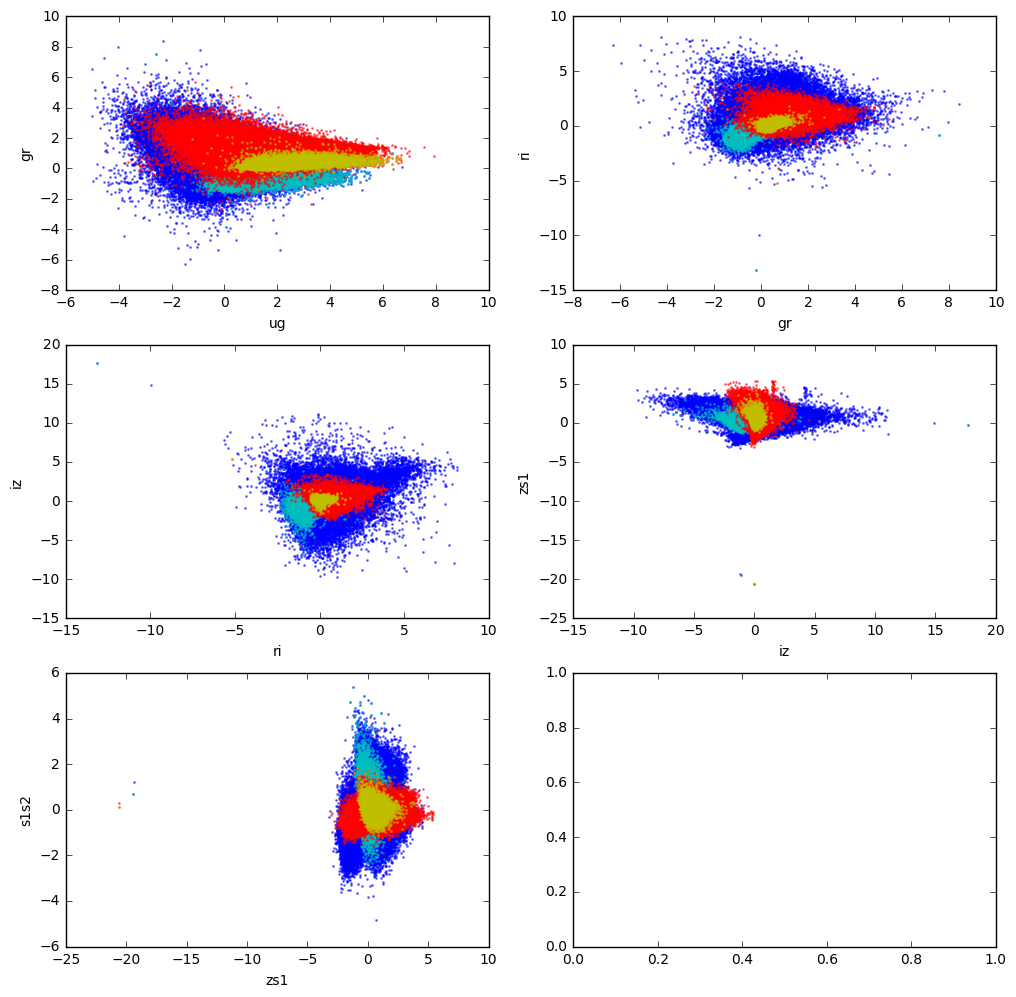

In [84]:
import matplotlib.gridspec as gridspec

gdx = y == 0

fig = plt.figure(1,figsize = (12,12))

gs = gridspec.GridSpec(3,2)#,width_ratios = [1,1,1,1,1,1], height_ratios = [1,1,1,1,1,1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

for i in range(5):
    name = [ax0,ax1,ax2,ax3,ax4,ax5]
    lab = ['ug','gr','ri','iz','zs1','s1s2']
    plt.axes(name[i])
    plt.scatter(XS[:,i],XS[:,i+1],s=1,alpha=0.5,color = 'b')
    plt.scatter(XS[:,i][gdx],XS[:,i+1][gdx],s=1,alpha=0.5,color = 'c')
    plt.scatter(X[:,i],X[:,i+1],s=1,alpha=0.5,color = 'r')
    plt.scatter(X[:,i][gdx],X[:,i+1][gdx],s=1,alpha=0.5,color = 'y')
    plt.xlabel(lab[i])
    plt.ylabel(lab[i+1])


plt.show()


---
## Neural Network Classification

Let's start by trying a neural network.  (More because that's the last thing that I taught than anything else.)  Set `random_state` so that this is repeatable.

In [18]:
# Neural Network
from sklearn.neural_network import MLPClassifier
# Instantiate the classifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
# Train the classifier with the training subset
nn.fit(Xtrain, ytrain)

# Now predict the labels for the test data
# ypred = clf.predict(Xtest)
# Added timing function for comparison with other methods.
ypred = nn.predict(Xtest)

In [19]:
# The classification report gives:
# efficiency = precision
# completeness = recall
# while the f1-score is a combination of the two
print(classification_report(ytest, ypred, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.87      0.80      0.83      5670
      stars       0.99      1.00      0.99    169554

avg / total       0.99      0.99      0.99    175224



So that is 70% complete with 12% contamination (where some of that contamination will be from $z<3.5$ quasars rather than from stars.)

The above only classifies 25% of the data.  To find the self-classification for all the training objects we can do a cross-validation instead which averages over all of the results, using N different subsamples for testing.

In [20]:
N = 5
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
ypredCV = cross_val_predict(clf, X, y, cv=N) # Note that we use X and y and not Xtrain and ytrain
print(classification_report(y, ypredCV, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.83      0.80      0.82     22752
      stars       0.99      0.99      0.99    678142

avg / total       0.99      0.99      0.99    700894



---
## SVM Classification

Now try classifcation with [SVM](http://scikit-learn.org/stable/modules/svm.html).

In [3]:
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(Xtrain, ytrain)

ypredSVM = svm.predict(Xtest)
print(classification_report(ytest, ypredSVM, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.85      0.79      0.82      4277
      stars       0.99      1.00      1.00    170916

avg / total       0.99      0.99      0.99    175193



Pretty good.  81% completeness and 89% efficiency.

Do it again with scaled data to see if that makes any difference.
It doesn't seem to for colors alone, but might for other attributes?

In [4]:
from sklearn.svm import SVC

svm = SVC(random_state=42)
svm.fit(XStrain, yStrain)

ySpredSVM = svm.predict(XStest)
print(classification_report(yStest, ySpredSVM, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.89      0.82      0.85      5669
      stars       0.99      1.00      1.00    169524

avg / total       0.99      0.99      0.99    175193



In [5]:
print len(ySpredSVM), len(yStest)
good = ySpredSVM == 0

qq = ((yStest==0) & (ySpredSVM==0))
ss = ((yStest==1) & (ySpredSVM==1))
qs = ((yStest==0) & (ySpredSVM==1))
sq = ((yStest==1) & (ySpredSVM==0))


print len(ySpredSVM[qq]), "quasars selected as quasars"
print len(ySpredSVM[qs]), "quasars selected as stars"
print len(ySpredSVM[sq]), "stars selected as quasars"



175193 175193
4634 quasars selected as quasars
1035 quasars selected as stars
562 stars selected as quasars


             precision    recall  f1-score   support

       QSOs       0.40      0.82      0.54     22722
      stars       0.99      0.96      0.98    678050

avg / total       0.97      0.95      0.96    700772

18599 quasars selected as quasars
4123 quasars selected as stars
27717 stars selected as quasars


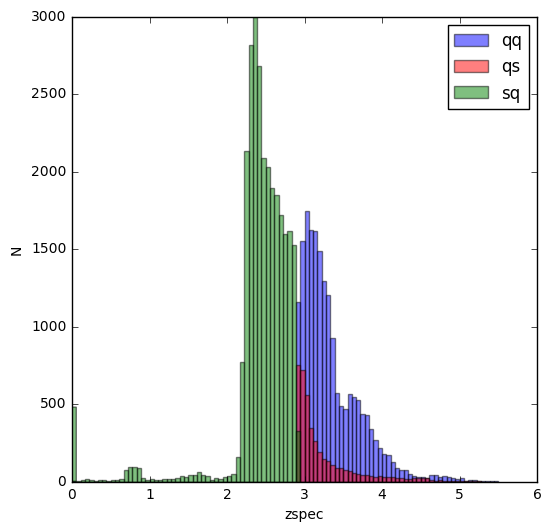

In [6]:
ypredCVSVM = cross_val_predict(svm, XS, y)
data['ypred'] = ypredCVSVM

print(classification_report(y, ypredCVSVM, target_names=['QSOs', 'stars']))

qq = ((data[labname]==0) & (data['ypred']==0))
ss = ((data[labname]==1) & (data['ypred']==1))
qs = ((data[labname]==0) & (data['ypred']==1))
sq = ((data[labname]==1) & (data['ypred']==0))
dataqq = data[qq]
datass = data[ss]
dataqs = data[qs]
datasq = data[sq]

print len(dataqq), "quasars selected as quasars"
print len(dataqs), "quasars selected as stars"
print len(datasq), "stars selected as quasars"

fig = plt.figure(figsize=(6, 6))
bins=np.linspace(0,5.5,100)
plt.hist(dataqq['zspec'],bins=bins,label='qq',color='b',alpha=0.5)
plt.hist(dataqs['zspec'],bins=bins,label='qs',color='r',alpha=0.5)
plt.hist(datasq['zspec'],bins=bins,label='sq',color='g',alpha=0.5)
#plt.xlim([-4,8])
#plt.ylim([-1.5,1.5])
plt.legend()
plt.xlabel('zspec')
plt.ylabel('N')

Plot the colors of the classified objects from above

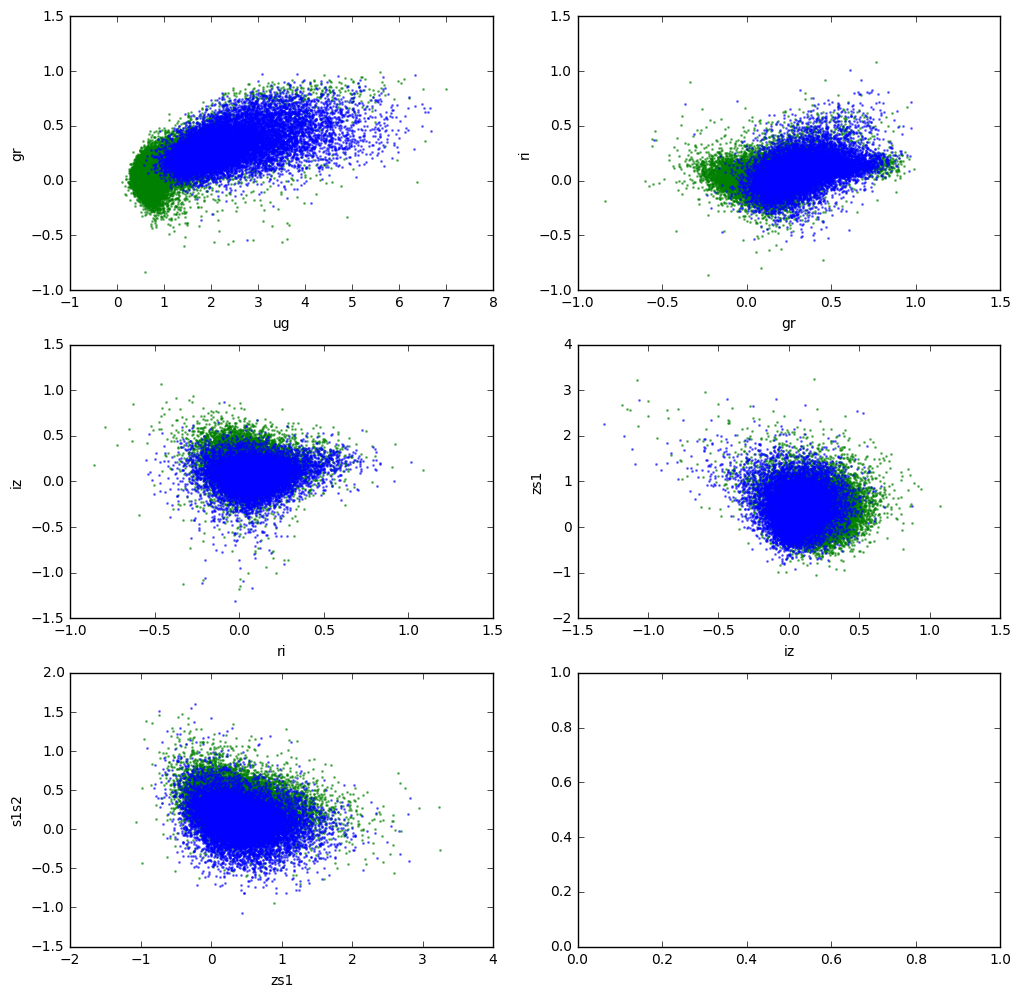

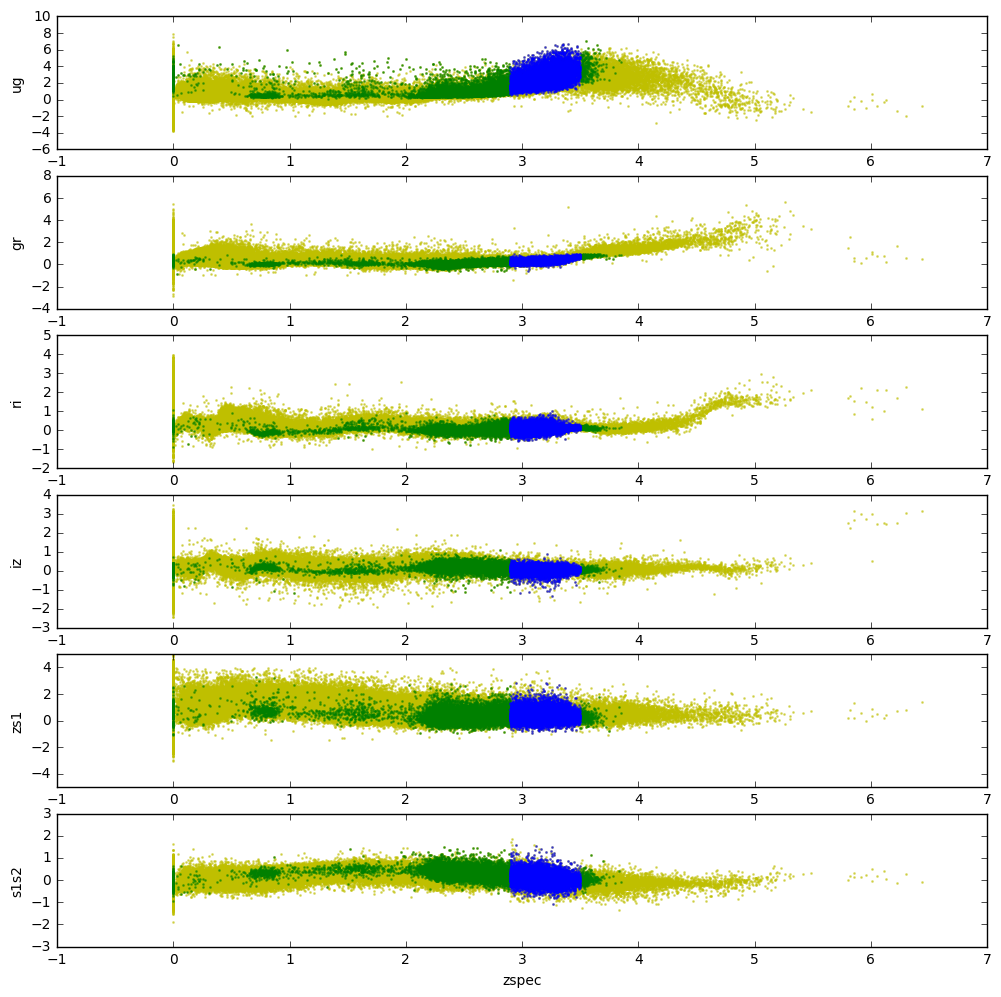

In [11]:
import matplotlib.gridspec as gridspec


fig = plt.figure(5,figsize = (12,12))

gs = gridspec.GridSpec(3,2)#,width_ratios = [1,1,1,1,1,1], height_ratios = [1,1,1,1,1,1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

for i in range(5):
    name = [ax0,ax1,ax2,ax3,ax4,ax5]
    lab = ['ug','gr','ri','iz','zs1','s1s2']
    plt.axes(name[i])
    plt.scatter(data[lab[i]][qq],data[lab[i+1]][qq],s=1,alpha=0.5,color = 'b',zorder = 2)
    plt.scatter(data[lab[i]][sq],data[lab[i+1]][sq],s=1,alpha=0.5,color = 'g')
    #plt.scatter(data[lab[i]][qs],data[lab[i+1]][qs],s=1,alpha=0.5,color = 'r')
    #plt.scatter(XStest[:,i][bdx],XStest[:,i+1][bdx],s=1,alpha=1,color = 'y')
    plt.xlabel(lab[i])
    plt.ylabel(lab[i+1])

fig = plt.figure(6,figsize = (12,12))

gs = gridspec.GridSpec(6,1)#,width_ratios = [1,1,1,1,1,1], height_ratios = [1,1,1,1,1,1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)
ax2 = plt.subplot(gs[2],sharex = ax0)
ax3 = plt.subplot(gs[3],sharex = ax0)
ax4 = plt.subplot(gs[4],sharex = ax0)
ax5 = plt.subplot(gs[5],sharex = ax0)

for i in range(6):
    name = [ax0,ax1,ax2,ax3,ax4,ax5]
    lab = ['ug','gr','ri','iz','zs1','s1s2']
    plt.axes(name[i])
    plt.scatter(data['zspec'],data[lab[i]],s=1,alpha=0.5,color = 'y')
    plt.scatter(data['zspec'][qq],data[lab[i]][qq],s=1,alpha=0.5,color = 'b',zorder = 2)
    plt.scatter(data['zspec'][sq],data[lab[i]][sq],s=1,alpha=0.5,color = 'g')
    #plt.scatter(data[lab[i]][qs],data[lab[i+1]][qs],s=1,alpha=0.5,color = 'r')
    #plt.scatter(XStest[:,i][bdx],XStest[:,i+1][bdx],s=1,alpha=1,color = 'y')
    plt.xlabel('zspec')
    plt.ylabel(lab[i])
    if lab[i] == 'zs1':
        plt.ylim(-5,5)
    
plt.show()


---
## Random Forest Classification

Now we'll try a DecisionTree, a RandomForest, and an ExtraTrees classifier

Note that `n_jobs=-1` is supposed to allow it to use multiple processesors if it can, but I'm honestly not sure how that works (and also not convinced that it isn't causing problems as sometimes when I use it I get a warning that it is setting `n_jobs=1` instead.

In [5]:
# Random Forests, etc.
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

clfDTC = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42)
clfRFC = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
clfETC = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42)

clfDTC.fit(Xtrain, ytrain)
clfRFC.fit(Xtrain, ytrain)
clfETC.fit(Xtrain, ytrain)

ypredDTC = clfDTC.predict(Xtest)
ypredRFC = clfRFC.predict(Xtest)
ypredETC = clfETC.predict(Xtest)

In [6]:
print clfDTC.feature_importances_
print clfRFC.feature_importances_
print clfETC.feature_importances_

print(classification_report(ytest, ypredDTC, target_names=['QSOs', 'stars']))
print(classification_report(ytest, ypredRFC, target_names=['QSOs', 'stars']))
print(classification_report(ytest, ypredETC, target_names=['QSOs', 'stars']))

[ 0.37212396  0.07057137  0.23637575  0.10749466  0.16734857  0.04608568]
[ 0.47601925  0.09610832  0.15028887  0.08550609  0.12263416  0.06944331]
[ 0.32658573  0.12038035  0.19769439  0.12807843  0.13700452  0.09025658]
             precision    recall  f1-score   support

       QSOs       0.79      0.79      0.79      5670
      stars       0.99      0.99      0.99    169554

avg / total       0.99      0.99      0.99    175224

             precision    recall  f1-score   support

       QSOs       0.87      0.84      0.85      5670
      stars       0.99      1.00      1.00    169554

avg / total       0.99      0.99      0.99    175224

             precision    recall  f1-score   support

       QSOs       0.86      0.82      0.84      5670
      stars       0.99      1.00      0.99    169554

avg / total       0.99      0.99      0.99    175224



In [7]:
# Random Forests, etc.
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
#Decision tree on scaled data
clfDTC = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42)
clfRFC = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
clfETC = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42)

clfDTC.fit(XStrain, yStrain)
clfRFC.fit(XStrain, yStrain)
clfETC.fit(XStrain, yStrain)

ypredDTC = clfDTC.predict(XStest)
ypredRFC = clfRFC.predict(XStest)
ypredETC = clfETC.predict(XStest)

print clfDTC.feature_importances_
print clfRFC.feature_importances_
print clfETC.feature_importances_

print(classification_report(yStest, ypredDTC, target_names=['QSOs', 'stars']))
print(classification_report(yStest, ypredRFC, target_names=['QSOs', 'stars']))
print(classification_report(yStest, ypredETC, target_names=['QSOs', 'stars']))

[ 0.37618534  0.07106014  0.2367257   0.10629851  0.16399232  0.04573799]
[ 0.44926946  0.09449102  0.13383142  0.0909815   0.11746688  0.11395972]
[ 0.36816696  0.11178238  0.16211745  0.11877935  0.12123659  0.11791727]
             precision    recall  f1-score   support

       QSOs       0.78      0.78      0.78      5669
      stars       0.99      0.99      0.99    169524

avg / total       0.99      0.99      0.99    175193

             precision    recall  f1-score   support

       QSOs       0.86      0.84      0.85      5669
      stars       0.99      1.00      1.00    169524

avg / total       0.99      0.99      0.99    175193

             precision    recall  f1-score   support

       QSOs       0.87      0.82      0.84      5669
      stars       0.99      1.00      0.99    169524

avg / total       0.99      0.99      0.99    175193



             precision    recall  f1-score   support

       QSOs       0.43      0.83      0.56     22722
      stars       0.99      0.96      0.98    678050

avg / total       0.98      0.96      0.96    700772

18863 quasars selected as quasars
3859 quasars selected as stars
25345 stars selected as quasars


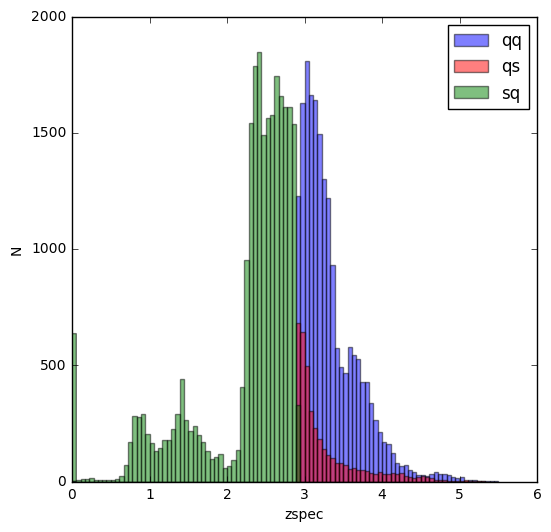

In [8]:
ypredCVRFC = cross_val_predict(clfRFC, XS, y)
data['ypred'] = ypredCVRFC
print(classification_report(y, ypredCVRFC, target_names=['QSOs', 'stars']))

qq = ((data[labname]==0) & (data['ypred']==0))
ss = ((data[labname]==1) & (data['ypred']==1))
qs = ((data[labname]==0) & (data['ypred']==1))
sq = ((data[labname]==1) & (data['ypred']==0))
dataqq = data[qq]
datass = data[ss]
dataqs = data[qs]
datasq = data[sq]

print len(dataqq), "quasars selected as quasars"
print len(dataqs), "quasars selected as stars"
print len(datasq), "stars selected as quasars"

fig = plt.figure(figsize=(6, 6))
bins=np.linspace(0,5.5,100)
plt.hist(dataqq['zspec'],bins=bins,label='qq',color='b',alpha=0.5)
plt.hist(dataqs['zspec'],bins=bins,label='qs',color='r',alpha=0.5)
plt.hist(datasq['zspec'],bins=bins,label='sq',color='g',alpha=0.5)
#plt.xlim([-4,8])
#plt.ylim([-1.5,1.5])
plt.legend()
plt.xlabel('zspec')
plt.ylabel('N')

---
## Bagging

Now we'll try a bagging classifier, based on K Nearest Neighbors.  I did some playing around with `max_samples` and `max_features` (both of which run from 0 to 1) and found 0.5 and 1.0 to work best.  Note that you have to give 1.0 in decimal otherwise it takes it to be 1 feature instead of 100% of them.

In [15]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=1.0, random_state=42, n_jobs=-1)
bagging.fit(Xtrain, ytrain)
ypredBag = bagging.predict(Xtest)
                           
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=7), max_samples=0.5, max_features=1.0, random_state=42, n_jobs=-1)
bagging.fit(Xtrain, ytrain)
ypredBag = bagging.predict(Xtest)
print "7 neighbors"
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.87      0.81      0.84      5670
      stars       0.99      1.00      0.99    169554

avg / total       0.99      0.99      0.99    175224



This seems to work better than the RandomForest.  Might be worth trying to optimize the parameters for this.  First try `n_neighbors=7`.  The default is 5.

Now do the same with the scaled data.

In [4]:
# Bagging Scaled data; 7 neighbors
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=30), max_samples=0.5, max_features=1.0, random_state=42, n_jobs=-1)
bagging.fit(XStrain, yStrain)
ypredBag = bagging.predict(XStest)
                           
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.85      0.80      0.82      4260
      stars       0.99      1.00      1.00    170964

avg / total       0.99      0.99      0.99    175224



Basically the same with 7 neighbors instead of the default of 5.  Scaled seems to be somewhat better than not. Try cross-validation.

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
N = 5
clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=7), max_samples=0.5, max_features=1.0, random_state=42, n_jobs=-1)
ypredCVBAG = cross_val_predict(clf, XS, y, cv=N)
print(classification_report(y, ypredCVBAG, target_names=['QSOs', 'stars']))



             precision    recall  f1-score   support

       QSOs       0.85      0.83      0.84     22722
      stars       0.99      0.99      0.99    678050

avg / total       0.99      0.99      0.99    700772



18834 quasars selected as quasars
3888 quasars selected as stars
3416 stars selected as quasars


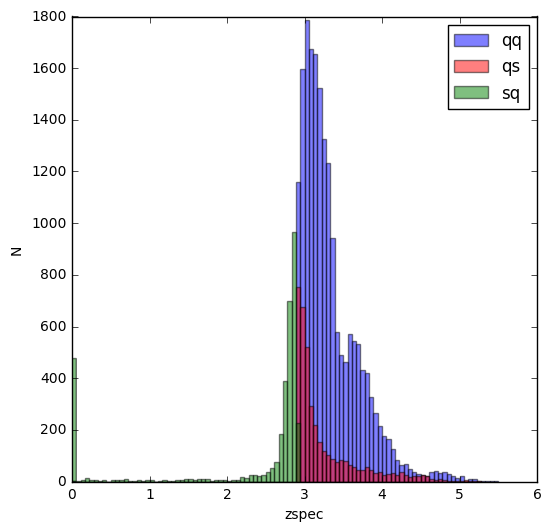

In [10]:
#Plot the cross-validation
data['ypred'] = ypredCVBAG
qq = ((data[labname]==0) & (data['ypred']==0))
ss = ((data[labname]==1) & (data['ypred']==1))
qs = ((data[labname]==0) & (data['ypred']==1))
sq = ((data[labname]==1) & (data['ypred']==0))
dataqq = data[qq]
datass = data[ss]
dataqs = data[qs]
datasq = data[sq]

print len(dataqq), "quasars selected as quasars"
print len(dataqs), "quasars selected as stars"
print len(datasq), "stars selected as quasars"

fig = plt.figure(figsize=(6, 6))
bins=np.linspace(0,5.5,100)
plt.hist(dataqq['zspec'],bins=bins,label='qq',color='b',alpha=0.5)
plt.hist(dataqs['zspec'],bins=bins,label='qs',color='r',alpha=0.5)
plt.hist(datasq['zspec'],bins=bins,label='sq',color='g',alpha=0.5)
#plt.xlim([-4,8])
#plt.ylim([-1.5,1.5])
plt.legend()
plt.xlabel('zspec')
plt.ylabel('N')

[ 0.02777778  0.08333333  0.13888889  0.19444444  0.25        0.30555556
  0.36111111  0.41666667  0.47222222  0.52777778  0.58333333  0.63888889
  0.69444444  0.75        0.80555556  0.86111111  0.91666667  0.97222222
  1.02777778  1.08333333  1.13888889  1.19444444  1.25        1.30555556
  1.36111111  1.41666667  1.47222222  1.52777778  1.58333333  1.63888889
  1.69444444  1.75        1.80555556  1.86111111  1.91666667  1.97222222
  2.02777778  2.08333333  2.13888889  2.19444444  2.25        2.30555556
  2.36111111  2.41666667  2.47222222  2.52777778  2.58333333  2.63888889
  2.69444444  2.75        2.80555556  2.86111111  2.91666667  2.97222222
  3.02777778  3.08333333  3.13888889  3.19444444  3.25        3.30555556
  3.36111111  3.41666667  3.47222222  3.52777778  3.58333333  3.63888889
  3.69444444  3.75        3.80555556  3.86111111  3.91666667  3.97222222
  4.02777778  4.08333333  4.13888889  4.19444444  4.25        4.30555556
  4.36111111  4.41666667  4.47222222  4.52777778  4

/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


(0, 1)

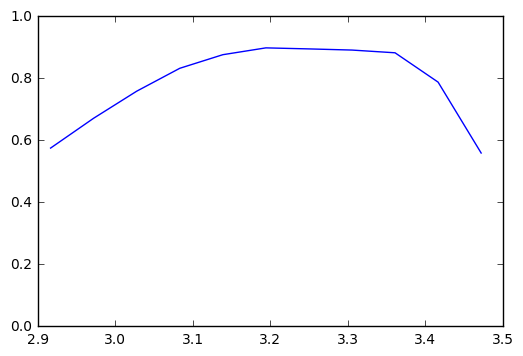

In [16]:
#print selection fraction
bins=np.linspace(0,5.5,100)
hz, bins = np.histogram(data['zspec'][data[labname]==0],bins)
recovered,bins = np.histogram(dataqq['zspec'],bins)

frac = np.asarray(recovered)*1.0/np.asarray(hz)
mdpt = (bins[:-1]+bins[1:])/2.0

print mdpt
print hz
print recovered

print frac

plt.plot(mdpt, frac)
plt.ylim(0,1)

---
## Boosting

Now try a boosting-based classifier.

In [23]:
# Boosting
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
boost.fit(Xtrain, ytrain)
ypredBoost = boost.predict(Xtest)

print f1_score(ytest, ypredBoost)
print(classification_report(ytest, ypredBoost, target_names=['QSOs', 'stars']))
print boost.feature_importances_

0.999098150774
             precision    recall  f1-score   support

       QSOs       0.91      0.78      0.84      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

[ 0.27386614  0.21087245  0.23887571  0.12073587  0.09678462  0.05886521]


Also pretty good, but not the best so far.  This algorithm outputs the importances of the features, which shows that $u-g$ is the most important with $r-i$ being next.

The main parameter for boosting is the depth of the underlying trees.  Let's make that a parameter and do a grid search over a range of depths.  The training set should always improve with greater depth, but the test set will plateau.  That's the value that we want for the depth.

In [24]:
# Depth-optimized Boosting
depth = np.arange(1, 10)
score_test = np.zeros(len(depth))
score_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

# Loop over the depths
for i, d in enumerate(depth):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=d, random_state=42) 
    clf.fit(Xtrain, ytrain)

    ypredtrain = clf.predict(Xtrain)
    # We need some way to decide what is best
    # Try using the f1_score and comparing the values for the different depths
    score_train[i] = f1_score(ytrain, ypredtrain)
   
    ypredtest = clf.predict(Xtest)
    score_test[i] = f1_score(ytest, ypredtest)

    if score_test[i] >= score_test[i_best]:
        i_best = i
        ybest = ypredtest

best_depth = depth[i_best]

# Give the best depth and the corresponding classification report.
print best_depth
print(classification_report(ytest, ybest, target_names=['QSOs', 'stars']))

3
             precision    recall  f1-score   support

       QSOs       0.91      0.73      0.81      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



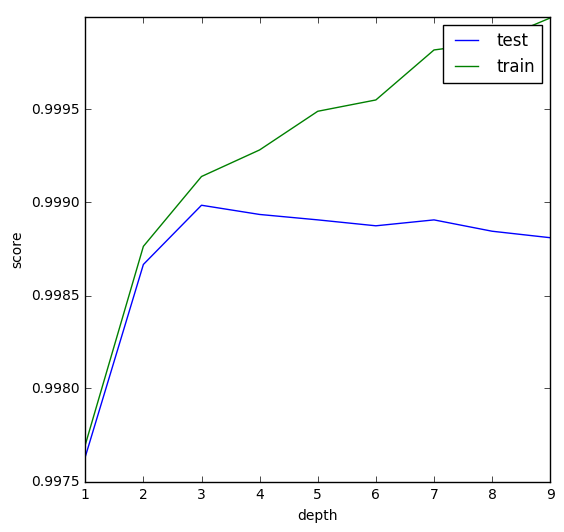

In [25]:
# Plot the f1 score vs. depth
fig = plt.figure(figsize=(6, 6))
plt.plot(depth,score_test,label='test')
plt.plot(depth,score_train,label='train')
plt.xlabel("depth")
plt.ylabel("score")
plt.legend()
plt.show()

This suggests that a depth of 3 is optimal.

---
RandomForests were better than Boosting, so let's try optimizing the depth for RandomForests.

In [26]:
# Depth-optimized Random Forest
depth = np.arange(10, 21)
score_test = np.zeros(len(depth))
score_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

for i, d in enumerate(depth):
    clf = RandomForestClassifier(n_estimators=10, max_depth=d, min_samples_split=2, random_state=42, n_jobs=-1)
    clf.fit(Xtrain, ytrain)

    ypredtrain = clf.predict(Xtrain)
    score_train[i] = f1_score(ytrain, ypredtrain)
   
    ypredtest = clf.predict(Xtest)
    score_test[i] = f1_score(ytest, ypredtest)

    if score_test[i] >= score_test[i_best]:
        i_best = i
        ybest = ypredtest

best_depth = depth[i_best]
print best_depth
print(classification_report(ytest, ybest, target_names=['QSOs', 'stars']))

17
             precision    recall  f1-score   support

       QSOs       0.93      0.78      0.85      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



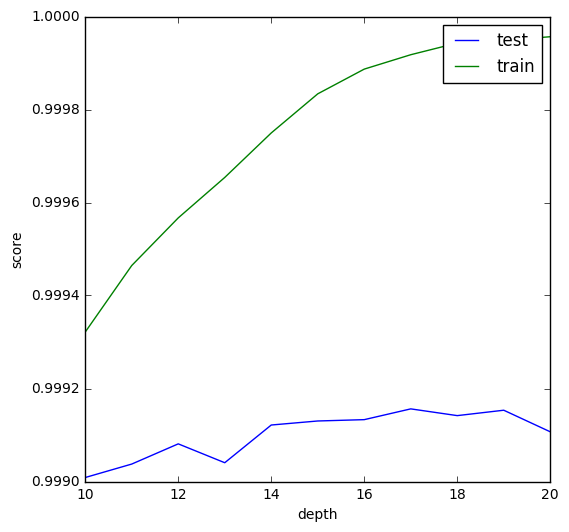

In [27]:
fig = plt.figure(figsize=(6, 6))
plt.plot(depth,score_test,label='test')
plt.plot(depth,score_train,label='train')
plt.xlabel("depth")
plt.ylabel("score")
plt.legend()
plt.show()

So far a `depth=17` RandomForest is giving the best results:

78% Completeness
7% Contamination

Though we might be able to optimize more by tweaking the other paramters.

In [28]:
# Try increasing the number of estimators
clf = RandomForestClassifier(n_estimators=20, max_depth=15, min_samples_split=2, random_state=42, n_jobs=-1)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.76      0.84      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Somehow this isn't quite as good, so stick with 10 estimators.

But first need to produce classifications for all using cross-validation and the parameters above.

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
clf = RandomForestClassifier(n_estimators=10, max_depth=15, min_samples_split=2, n_jobs=-1, random_state=42)
N=5
ypredCV = cross_val_predict(clf, X, y, cv=N)

print(classification_report(y, ypredCV, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.92      0.79      0.85      4193
      stars       1.00      1.00      1.00    689365

avg / total       1.00      1.00      1.00    693558



Final result is 79% completeness and 8% contamination.

Should output the classification vector and do some exploring in TOPCAT with it.

Create a new Table column for `data` filled with the predicted $y$ values.  Then write it out as FITS.

In [30]:
data['ypred'] = ypredCV

In [57]:
# Input file output with results of self-classification with RF
data.write('GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean_class.fits', format='fits')

Make the same histograms as above.

In [31]:
qq = ((data['shenlabel']==0) & (data['ypred']==0))
ss = ((data['shenlabel']==1) & (data['ypred']==1))
qs = ((data['shenlabel']==0) & (data['ypred']==1))
sq = ((data['shenlabel']==1) & (data['ypred']==0))
dataqq = data[qq]
datass = data[ss]
dataqs = data[qs]
datasq = data[sq]

print len(dataqq), "quasars selected as quasars"
print len(dataqs), "quasars selected as stars"
print len(datasq), "stars selected as quasars"

3300 quasars selected as quasars
893 quasars selected as stars
288 stars selected as quasars


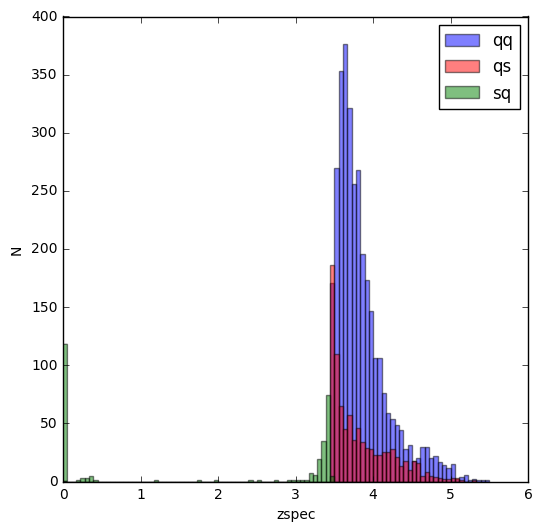

In [32]:
fig = plt.figure(figsize=(6, 6))
bins=np.linspace(0,5.5,100)
plt.hist(dataqq['zspec'],bins=bins,label='qq',color='b',alpha=0.5)
plt.hist(dataqs['zspec'],bins=bins,label='qs',color='r',alpha=0.5)
plt.hist(datasq['zspec'],bins=bins,label='sq',color='g',alpha=0.5)
#plt.xlim([-4,8])
#plt.ylim([-1.5,1.5])
plt.legend()
plt.xlabel('zspec')
plt.ylabel('N')

This is actually worse that for both SVM and Bagging.  But it is what I decided to go with for the first comparison with KDE.  We'll come back and look at this more in the next notebook.  However, it is clear that we might want to use something else if contamination is the main thing that we are worried about.

What is interesting is that about half of the "stars" are quasars with $\lesssim3.5$.
So, the contamination is more like 4% than 8%.

Similarly, most of the failed quasars are at $z\gtrsim3$, which isn't all that surprising.

In [38]:
print len(Xtest)

173390


### Timing test

One of the reasons that I settled on RF is shown by the timing analysis below.  While the bagging analysis works well, it takes *forever*.  For just 173,390 sources bagging takes 32.8s as compared to 129ms for RF and SVM takes 7.45s.

So the prediction for classifying 50 million sources is:<br>
RF 37 seconds<br>
SVM 35.8 minutes<br>
BAG 2.62 hours

In [34]:
%timeit -n1 ypred = nn.predict(Xtest)

1 loop, best of 3: 15.1 ms per loop


In [35]:
%timeit -n1 ypredRFC = clfRFC.predict(Xtest)

1 loop, best of 3: 129 ms per loop


In [37]:
%timeit -n1 ypredBag = bagging.predict(XStest)

1 loop, best of 3: 32.8 s per loop


In [39]:
%timeit -n1 ySpredSVM = svm.predict(XStest)

1 loop, best of 3: 7.45 s per loop


## Comparison with KDE Results
    
Assuming class1 is stars and class2 is quasars:<br>
  689365 true stars.  4193 true quasars.<br>
  690189 points were labeled as stars.<br>
  3369 points were labeled as quasars.<br><br>
  689273 out of 689365 stars were labeled as stars (99.99%).<br>
  92 out of 689365 stars were labeled as quasars (0.01335%).<br>
  916 out of 4193 quasars were labeled as stars (21.85%).<br>
  3277 out of 4193 quasars were labeled as quasars (78.15%).<br><br>
Overall Accuracy: 99.85%<br>
Weighted Accuracy: 89.07%<br>
Completeness: 78.15%<br>
Efficiency: 97.27%<br>
Rating: 0.7602<br>

This is about as good as the KDE results (at least for self classification), which got 78% completeness with 97% efficiency (where some of those stars classified as quasars are also likely $z\sim3.5$).  The combination of these suggests that the candidate list that John is using should has 3% or less contamination.  We can check that by also testing the photo-z's.

Make a few plots illustrating that not all of the contamination is from stars (but is instead from $z\lesssim3.5$).

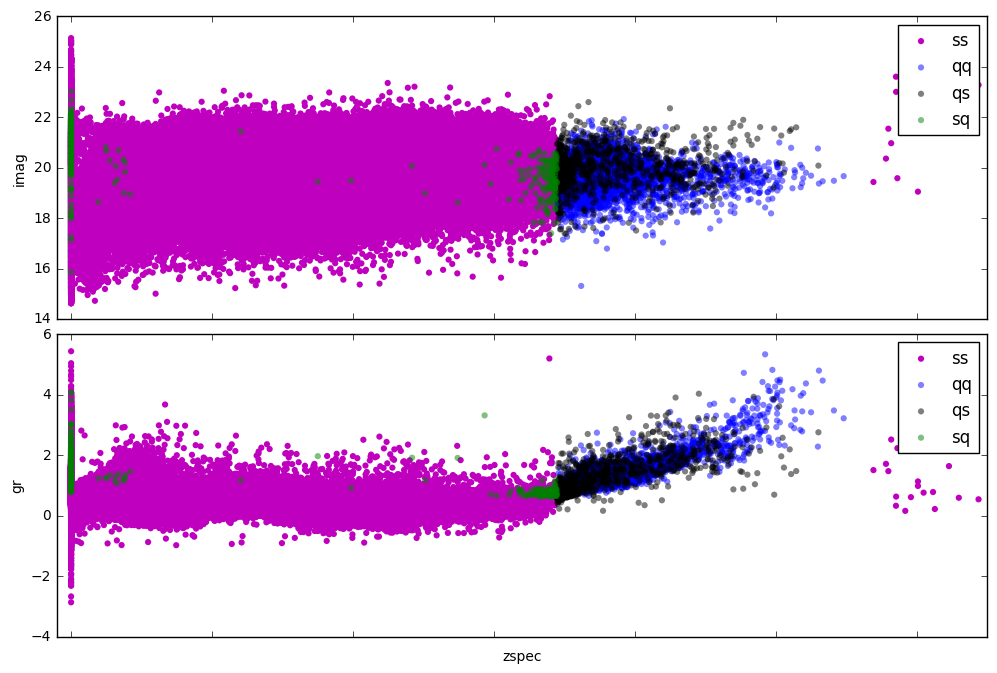

In [68]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.05)
ax1 = fig.add_subplot(211)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
plt.scatter(datass['zspec'],datass['imag'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['zspec'],dataqq['imag'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['zspec'],dataqs['imag'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['zspec'],datasq['imag'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-0.1,6.5])
plt.xlabel('zspec')
plt.ylabel('imag')

ax2 = fig.add_subplot(212, sharex=ax1)
plt.scatter(datass['zspec'],datass['gr'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['zspec'],dataqq['gr'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['zspec'],dataqs['gr'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['zspec'],datasq['gr'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-0.1,6.5])
plt.xlabel('zspec')
plt.ylabel('gr')

plt.show()

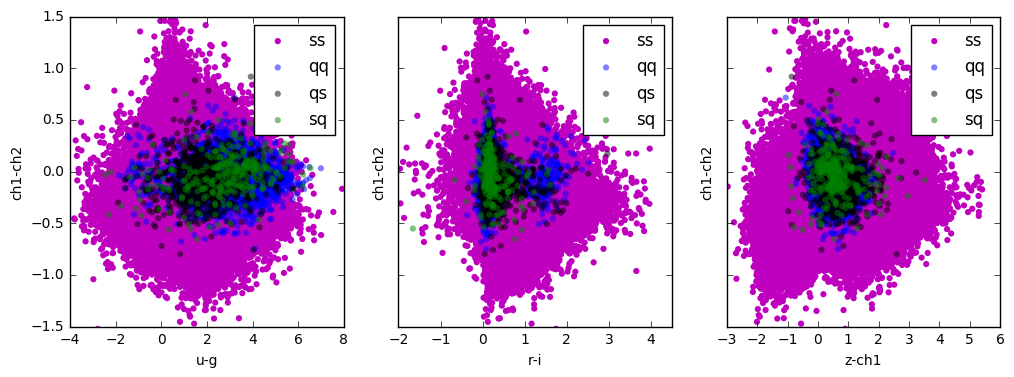

In [71]:
fig = plt.figure(figsize=(12, 4))
#fig.subplots_adjust(vspace=0.05)
ax1 = fig.add_subplot(131)
plt.scatter(datass['ug'],datass['s1s2'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['ug'],dataqq['s1s2'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['ug'],dataqs['s1s2'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['ug'],datasq['s1s2'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-4,8])
plt.ylim([-1.5,1.5])
plt.xlabel('u-g')
plt.ylabel('ch1-ch2')

ax2 = fig.add_subplot(132)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
plt.scatter(datass['ri'],datass['s1s2'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['ri'],dataqq['s1s2'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['ri'],dataqs['s1s2'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['ri'],datasq['s1s2'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-2,4.5])
plt.ylim([-1.5,1.5])
plt.xlabel('r-i')
plt.ylabel('ch1-ch2')

ax3 = fig.add_subplot(133)
ax3.yaxis.set_major_formatter(plt.NullFormatter())
plt.scatter(datass['zs1'],datass['s1s2'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['zs1'],dataqq['s1s2'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['zs1'],dataqs['s1s2'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['zs1'],datasq['s1s2'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-3,6])
plt.ylim([-1.5,1.5])
plt.xlabel('z-ch1')
plt.ylabel('ch1-ch2')

plt.show()

These are more revealing as contours or density plots (which I examined in TOPCAT), but I'm going to leave them as they are for now.

---

See more in further notebooks.